In [1]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy

nlp = spacy.load('en_core_web_sm')
tokenizer = ToktokTokenizer()


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1] # technology
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [9]:
news_df = build_dataset(seed_urls)
news_df.head()

,news_headline,news_article,news_category
0,Get your home festive ready with Alexa Smart H...,In the lead-up to Amazon Great Indian Festival...,technology
1,"After camera issue with 3rd party apps, iPhone...",After several iPhone 14 Pro users complained o...,technology
2,Wipro fires 300 employees found 'Moonlighting'...,Wipro terminated the services of 300 employees...,technology
3,Violation of integrity in its deepest form: Wi...,"Rishad Premji, Chairman of IT major Wipro whic...",technology
4,YouTuber purposely crashes car to test iPhone ...,'TechRax' YouTube channel's owner Taras Maksim...,technology


In [10]:
news_df.shape

(75, 3)

In [11]:
news_df['news_category'].value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

In [12]:
news_df.isna().sum()

news_headline    0
news_article     0
news_category    0
dtype: int64

In [1]:
#Contractions are shortened words, 
#e.g., don’t and can’t. Expanding such words to “do not” and “can not” helps to standardize text.
!pip install contractions
import contractions
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text
expand_contractions('don\'t to do')


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


'do not to do'

In [47]:
#Text Preprocessing

#1)Remove HTML Tags
#------------------------------------------------------------------------------------------
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text()
    return stripped_text
#------------------------------------------------------------------------------------------

#2)Remove Accended Characters
#------------------------------------------------------------------------------------------
import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
#------------------------------------------------------------------------------------------

#3)Remove Special Characters
#------------------------------------------------------------------------------------------
import re
def remove_special_characters(text, remove_digits=False):
    pattern='[^a-zA-Z0-9\s]' if not remove_digits else '[^a-zA-Z\s]'
    text = re.sub(pattern,'',text)
    return text

#------------------------------------------------------------------------------------------

#4)Stemming
#------------------------------------------------------------------------------------------
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#------------------------------------------------------------------------------------------

#5) Lemmatization
#------------------------------------------------------------------------------------------
#Spacy lemmatize gives more accurate results than the WordNetLemmatizer
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# def lemmatize_text_WN(text):
#     lem = WordNetLemmatizer()
#     text = ' '.join([lem.lemmatize(word.lower(), pos='v') for word in text.split()])
#     return text
#------------------------------------------------------------------------------------------

#6) Remove StopWords
#------------------------------------------------------------------------------------------
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

def remove_stop_words(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filterd_tokens= [token for token in tokens if token not in stopword_list]
    else:    
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#------------------------------------------------------------------------------------------

In [56]:
remove_stop_words("after camera issue with 3rd party apps, iPhone 14 Pro users complain of 'slow' Camera app")

"camera issue 3rd party apps , iPhone 14 Pro users complain ' slow ' Camera app"

In [31]:
lemmatize_text("Indiaing") 

'indiae'

In [16]:
#lemmatize_text_WN("My system keeps crashing his crashed yesterday, ours crashes daily") 

In [49]:
#Bring all Functions together
def normalize_corpus(corpus,html_stripping=True, 
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus=[]
    # normalize each document in the corpus
    for doc in corpus:
        #strip HTML
        if html_stripping:
            doc = remove_html_tags(doc)
        #Accended Characters removal    
        if accented_char_removal:
            doc=remove_accented_chars(doc)
        #Special Characters removal     
        if special_char_removal:
            doc = remove_special_characters(doc, remove_digits=False)
        #Lower case    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines    
        doc = re.sub(r'[\r|\n|\r\n]+',' ',doc)
        #Lemmatize
        if text_lemmatization:
            doc = lemmatize_text(doc)
        #Remove extra white spaces
        doc = re.sub(r' +',' ',doc)    
        if stopword_removal:
            doc = remove_stop_words(doc)
        
        
        normalized_corpus.append(doc)
        
    return normalized_corpus #Return on For loop exit
        

In [38]:
news_df.head(2)


,news_headline,news_article,news_category,Full Text,Clean Text
0,Get your home festive ready with Alexa Smart H...,In the lead-up to Amazon Great Indian Festival...,technology,Get your home festive ready with Alexa Smart H...,get your home festive ready with alexa smart h...
1,"After camera issue with 3rd party apps, iPhone...",After several iPhone 14 Pro users complained o...,technology,"After camera issue with 3rd party apps, iPhone...",after camera issue with 3rd party app iphone 1...


In [50]:
# combining headline and article text
news_df['Full Text'] = news_df['news_headline'] + '. ' + news_df['news_article']

In [51]:
news_df['Full Text'][0]

'Get your home festive ready with Alexa Smart Home Combo: Amazon. In the lead-up to Amazon Great Indian Festival, Amazon has announced that customers can convert their homes into smart homes with Alexa Smart Home combos starting at ₹1799. With the festival beginning from 23rd September, the brand aims to encourage people to get their wishlist ready before the sale.'

In [52]:
# pre-process text and store the same
news_df['Clean Text'] = normalize_corpus(news_df['Full Text'])

In [60]:
news_df.iloc[0][['Full Text','Clean Text']].to_dict()

{'Full Text': 'Get your home festive ready with Alexa Smart Home Combo: Amazon. In the lead-up to Amazon Great Indian Festival, Amazon has announced that customers can convert their homes into smart homes with Alexa Smart Home combos starting at ₹1799. With the festival beginning from 23rd September, the brand aims to encourage people to get their wishlist ready before the sale.',
 'Clean Text': 'get home festive ready alexa smart home combo amazon leadup amazon great indian festival amazon announce customer convert home smart home alexa smart home combo start 1799 festival begin 23rd september brand aim encourage people get wishlist ready sale'}

In [61]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

In [62]:
corpus = news_df['Clean Text']

In [98]:
#Lexion Based, Sentiment Analysis
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category=['Positive' if score >0 
                        else 'Negative' if score <0 
                           else 'neutral' 
                                for score in sentiment_scores]

# sentiment statistics per news category
df=pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns=['news_category', 'sentiment_scores', 'sentiment_category'] 
df['sentiment_scores']= df.sentiment_scores.astype('float')
df.groupby(df['news_category']).describe()

sentiment_scores                                           
                         count  mean       std   min  25%  50%  75%   max
news_category                                                            
sports                    25.0  4.16  6.128349  -6.0  0.0  3.0  7.0  18.0
technology                25.0 -0.88  6.495640 -18.0 -4.0 -1.0  2.0  11.0
world                     25.0 -3.32  5.956229 -14.0 -6.0 -4.0 -1.0  11.0

In [81]:
df.head()

,news_category,sentiment_scores,sentiment_category
0,technology,10.0,Positive
1,technology,-6.0,Negative
2,technology,-2.0,Negative
3,technology,-1.0,Negative
4,technology,-18.0,Negative


C:\Users\Kishore kumar V\pythonconda\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


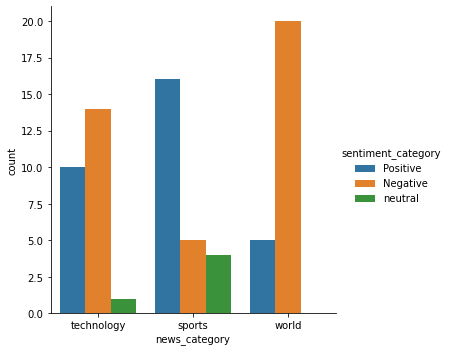

In [102]:
fc = sns.factorplot(x='news_category', hue='sentiment_category',
                    data = df, kind="count")

In [117]:
pos_indx = df[(df.news_category == 'technology')  & (df.sentiment_scores == 11.0)].index[0]
neg_indx=df[(df.news_category == 'technology') & (df.sentiment_scores == -6.0)].index[0]


In [125]:
print('Most positive news: ' , news_df.iloc[pos_indx][['news_article']][0])
print()
print('Most Negative News: ' , news_df.iloc[neg_indx][['news_article']][0])


Most positive news:  RBI is not interested in penalising fintechs or stifling innovation but wants them to follow the rules of the game, Governor Shaktikanta Das said on Tuesday. "RBI will continue to be supportive of [digital lending] and will welcome it. We will, in fact, go two steps forward to discuss with you if you just take one step forward," Das added.

Most Negative News:  After several iPhone 14 Pro users complained of camera issue while using third-party apps, several users have now complained of 'slow' Camera app. Users have suggested that the camera takes several seconds to load when the app is opened. The iOS 16.0.1 update does not appear to fix the issue for those who are impacted.
